# Installation

In [1]:
!apt install coinor-libipopt-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  coinor-libipopt1v5 libmumps-5.2.1 libmumps-dev libmumps-seq-5.2.1
  libmumps-seq-dev libscalapack-mpi-dev libscalapack-openmpi-dev
  libscalapack-openmpi2.1 libscotch-6.0
Suggested packages:
  scalapack-doc
The following NEW packages will be installed:
  coinor-libipopt-dev coinor-libipopt1v5 libmumps-5.2.1 libmumps-dev
  libmumps-seq-5.2.1 libmumps-seq-dev libscalapack-mpi-dev
  libscalapack-openmpi-dev libscalapack-openmpi2.1 libscotch-6.0
0 upgraded, 10 newly installed, 0 to remove and 22 not upgraded.
Need to get 9,766 kB of archives.
After this operation, 64.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libscalapack-openmpi2.1 amd64 2.1.0-2build1 [1,528 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libmumps-5.2.1 amd64 5.2.1-2build1 [1,619 kB]
Get:3 http://a

In [2]:
!pip install cyipopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cyipopt: filename=cyipopt-1.2.0-cp39-cp39-linux_x86_64.whl size=581035 sha256=c2b1e65fe3bfd190d9025f1ae4ca75b52d297ef58fbf92eb0ca6adf222506a58
  Stored in directory: /root/.cache/pip/wheels/c1/e3/a1/006d16ad562b055d05eff8ef361ef5a8b5d4d279e73560fe98
Successfully built cyipopt


# Dependencies

In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
import cyipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
from jax import jit, grad, jacfwd, jacrev

import jax
import jax.numpy as jnp

config.update('jax_platform_name', 'gpu')
# Enable 64 bit floating point precision
# config.update("jax_enable_x64", True)

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm

import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import cyipopt

import warnings
import matplotlib.pyplot as plt


import pickle
import sys

import numpy as np


# Default values

In [2]:
import os
os.environ["G_TOTAL"] = '101'
os.environ["G_MODEL"] = '80'
os.environ["MAX_TIME"] = '500'
os.environ["STEADY_TIME"] = '300'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_to_assets = '/content/drive/MyDrive/olg/assets'

In [5]:
import numpy as np
import os
class DefaultValues():
  def __init__(self):
    self.G_TOTAL = int(os.getenv('G_TOTAL'))
    self.G_MODEL = int(os.getenv('G_MODEL'))
    self.MAX_TIME = int(os.getenv('MAX_TIME'))
    self.STEADY_TIME = int(os.getenv('STEADY_TIME'))

    demo_scenario = os.getenv('demo_scenario', 'medium')
    oil_scenario = os.getenv('oil_scenario', 'mid')

    # # Precomputed blocks
    demography = np.load(os.path.join(path_to_assets, f'demography_{demo_scenario}.pickle'),allow_pickle='TRUE')

    oil = np.load(os.path.join(path_to_assets, f'oil_{oil_scenario}.pickle'),allow_pickle='TRUE')

    # Households
    self.utility = os.getenv('utility', 'exogenous_labor')
    self.phi = np.array([1, 1.28])
    self.upsilon = 5.
    self.beta = 0.975
    self.iota = np.array([0.8, 0.8])

    self.N, self.Pi, self.epsilon, self.rho, self.rho_reform = demography['population'], demography['survival_probability'],\
      demography['epsilon'], demography['rho'], demography['rho_reform']
      
    # World
    self.r = np.repeat(0.04, self.MAX_TIME)
    self.price_M = np.repeat(1., self.MAX_TIME)
    self.price_E = np.repeat(1., self.MAX_TIME)

    # Oil 
    self.Y_O , self.price_O, self.psi_O= oil['Y_O'], oil['price_O'], np.array(oil['psi_O'])

    # Production
    A_N = np.cumprod(np.concatenate(([1.],np.linspace(1.02,1.01,99), np.array([1.01 for _ in range(self.MAX_TIME-100)]))))
    A_E = np.cumprod(np.concatenate(([1.],np.linspace(1.02,1.01,99), np.array([1.01 for _ in range(self.MAX_TIME-100)]))))
    self.A = np.array([A_N, A_E])

    self.omega = 0.289
    self.alpha = 0.35
    self.psi = 1.5
    self.delta = 0.1

    GDP_initial = 103861.7
    K_initial = (GDP_initial - self.Y_O[0])*self.alpha / (self.r[0] + self.delta) # 205903
    K_E_initial = K_initial*0.168 # 34592 
    K_N_initial = K_initial*(1-0.168) # 171312

    I_initial = 22764.5
    I_N_initial = I_initial * (1-0.168)
    I_E_initial = I_initial * 0.168
    C_initial=52311

    # Population scaling
    L_initial = 1/(K_initial**self.alpha/ (GDP_initial - self.Y_O[0]))**(1/(1-self.alpha))
    L_unscaled = sum((self.phi[s] * self.N[s, :, 0] * self.epsilon[s, :, 0]).sum() for s in range(2))

    self.N = self.N * (L_initial / L_unscaled)

    L_N_initial = L_initial * (1-0.168)
    L_E_initial = L_initial * (0.168)





    # Taxes
    self.tau_I = np.repeat(0.13, self.MAX_TIME)
    self.tau_II = np.repeat(0., self.MAX_TIME)
    self.tau_Ins = np.repeat(0.08, self.MAX_TIME)
    self.tau_pi = np.repeat(0.2, self.MAX_TIME)
    self.tau_VA = np.repeat(0.2, self.MAX_TIME)
    self.tau_rho = np.repeat(0.22, self.MAX_TIME)
    self.tau_O = np.repeat(0.78, self.MAX_TIME)
    self.tax_LS = np.repeat(0.205, self.MAX_TIME)*A_N





    # Government
    self.sigma = np.array([np.repeat(0.293, self.MAX_TIME), np.repeat(0.33, self.MAX_TIME)])
    Gov_initial = 18394.
    Debt_initial = 9410
    self.target_debt_to_gdp = 0.2
    self.tax_sensitivity = {'VA_lag': 0.7, 'VA': 2.6, 'I': 0.0, 'I_lag': 0.0}
    Deficit_initial = 3035.6


    # Computation
    self.eta =0.25
    self.steady_max_iter=5000
    self.max_iter=500
    self.initial = {"price_N":1.,
            "K_N":K_N_initial,
            "L_N":L_N_initial,
            "I_N":I_N_initial,
            "K_E":K_E_initial,
            "L_E":L_E_initial,
            "I_E":I_E_initial,
            "C":C_initial,
            "Debt":Debt_initial,
            "Gov":Gov_initial, 
            "Deficit":Deficit_initial,
              "lmbda_E":0.5,
              "lmbda_N":0.5
    }
              
    self.steady_guess = np.array([2.65280161e+00, 7.20838767e-01, 1.02735785e+00, 3.30768049e+01,
       1.00000000e+00, 1.00000000e+00, 4.67438156e-01, 3.66973833e+05,
       1.64488185e+04, 2.78606328e+05])

In [6]:
default = DefaultValues()

# OLG model

In [7]:



def labor_income_vector(self, s, g, start, end):
    return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] +\
                                           self.tau_Ins[start:end])/(1+self.tau_rho[start:end] +\
                                                                     self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]

def inf_to_zero(x):
    x[~np.isfinite(x)] = 0
    return x
    
class OLG_model:
    def __init__(self,
                 G=default.G_MODEL,
                 T=default.STEADY_TIME,
                 N=default.N,
                 Pi=default.Pi,
                 MAX_TIME = default.MAX_TIME,
                 epsilon=default.epsilon,

                 beta=default.beta,
                 phi=default.phi,
                 upsilon = default.upsilon,
                 iota = default.iota,
                 utility = default.utility, # hybrid or exogenous_labor
                 
                 r=default.r,
                 price_M=default.price_M,
                 price_E=default.price_E,
                 omega=default.omega,
                 
                 alpha=default.alpha,
                 delta=default.delta,
                 psi=default.psi,
                 A=default.A,
                 
                 tau_I=default.tau_I,
                 tau_Ins=default.tau_Ins,
                 tau_pi=default.tau_pi,
                 tau_VA=default.tau_VA,
                 tau_rho=default.tau_rho,
                 tau_O = default.tau_O,
                 tax_LS = default.tax_LS,
                 
                 tax_sensitivity = default.tax_sensitivity,
                 target_debt_to_gdp = default.target_debt_to_gdp,
                 
                 sigma=default.sigma,
                 rho=default.rho,# or rho_reform
                 
                 price_O = default.price_O,
                 psi_O = default.psi_O,
                 Y_O = default.Y_O,
                 
                 initial=default.initial,
                 eta =default.eta,
                 steady_max_iter=default.steady_max_iter,
                 max_iter=default.max_iter,
                 steady_guess=default.steady_guess):
        """
        OLG model
        :param G: number of generations, default is 110
        :param T: simulation time, default is 500
        :param N_female: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param N_male: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param epsilon_female: female cohort- and year-specific productivity
        :param epsilon_male: male cohort- and year-specific productivity
        :param rho_female: female cohort- and year-specific retirement rate
        :param rho_male: male cohort- and year-specific retirement rate
        :param gov_strategy: "adaptive_gov", "adaptive_sigma", "adaptive_tau_rho", "unbalanced"
        :param gov_retirement_strategy: "unbalanced" for unbalanced retirement budget, "fixed_tau_rho" or "fixed_sigma" to zero-deficit retirement system
        :param sigma: pension rate (pension point value) as share of wage for T periods
        :param Pi_female: survival probability
        :param Pi_male: survival probability
        :param Beq_female_to_female,Beq_female_to_male,Beq_male_to_female,Beq_male_to_male: bequest matrix
        :param r: rate of return for T periods
        :param price_M: import prices for T periods
        :param price_E: export prices for T periods
        :param tau_I: income tax for T periods
        :param tau_Ins: insurance tax for T periods
        :param tau_pi: profit tax for T periods
        :param tau_VA: value-added tax for T periods
        :param tau_rho: retirement tax for T periods
        :param beta: discount factor
        :param phi: elasticity of intertemporal substitution
        :param psi: ? investment cost
        :param omega: import share
        :param alpha: elasticity of capital
        :param delta: deprecation rate
        :param A_N: total factor productivity, non-export good
        :param A_E: total factor productivity, export goods
        """

        ## Exogenous variables and parameters
        # Demography
        self.G, self.T,self.N,self.epsilon,self.Pi = G, T,N,epsilon,Pi
        # Utility
        self.beta, self.phi, self.upsilon, self.iota, self.utility = beta, phi,upsilon, iota,  utility
        
        
        # Prices
        self.r, self.price_M, self.price_E, self.omega= r, price_M, price_E, omega
        # Taxation
        self.tau_I,  self.tau_pi, self.tau_VA,self.tau_Ins, self.tau_rho, self.tau_O, self.tax_LS =  tau_I, tau_pi,tau_VA,tau_Ins, tau_rho, tau_O, tax_LS
        self.tax_sensitivity, self.target_debt_to_gdp = tax_sensitivity, target_debt_to_gdp
        self.target_tau_VA = tau_VA
        
        # Production
        self.psi, self.alpha, self.delta, self.A = psi, alpha, delta, A

        # Retirement
        self.rho, self.sigma = rho, sigma
        
        # Oil
        self.price_O = price_O
        self.psi_O = psi_O
        self.Y_O = Y_O

        self.initial = initial

        self.last_guess = None

        self.eta = eta
        self.steady_max_iter = steady_max_iter
        self.max_iter = max_iter
        self.max_time = MAX_TIME

        # Endogenous variable
        # Initial guess
        self.price_N = np.repeat(initial["price_N"], self.max_time)
        
        self.K = np.array([np.repeat(initial["K_N"], self.max_time),np.repeat(initial["K_E"], self.max_time)])

        self.L = np.array([np.repeat(initial["L_N"], self.max_time),np.repeat(initial["L_E"], self.max_time)])
        
        self.I = np.array([np.repeat(initial["I_N"], self.max_time),np.repeat(initial["I_E"], self.max_time)])
        
        
        self.Debt = np.repeat(initial["Debt"], self.max_time)
        
        self.lmbda = np.ones_like(self.K)

        self.w = np.ones(self.max_time)

        self.price = np.ones(self.max_time)


        
        self.k = np.ones_like(self.K)
        self.k_guess = self.k.copy()

        self.k[0,0] = self.K[0,0]/(self.L[:,0].sum()*self.A[0,0])
        self.k[0,1] = (self.K[0,0] * (1-self.delta) + self.I[0,0])/(self.L[:,1].sum() *self.A[0,1])
        
        self.k[1,0] = self.K[1,0] /(self.L[:,0].sum()*self.A[1,0])
        self.k[1,1] = (self.K[1,0] * (1-self.delta) + self.I[1,0])/(self.L[:,1].sum()*self.A[1,1])
        
        self.i = np.ones_like(self.I)
        self.i[0,0] = self.I[0,0]/self.K[0,0]
        self.i[1,0] = self.I[1,0]/self.K[1,0]
        self.i_guess = self.i.copy()        
        self.lmbda_to_price = np.ones_like(self.lmbda)

        self.l_demand = np.ones_like(self.L)
        self.l_demand[0] = self.L[0, 0]/self.L[:,0].sum()
        self.l_demand[1] = self.L[1, 0]/self.L[:,0].sum()
        
        self.gov_adaptation_time = None
        


        self.c =  np.array([[[0.5 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(self.max_time)] 
                             for g in range(self.max_time)] for _ in range(2)])
        
        self.a = np.array([[[0.1 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(self.max_time)] for g in range(self.max_time)] for _ in range(2)])
        
        self.gamma = np.array([[[0.9 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(self.max_time)] for g in range(self.max_time)] for _ in range(2)])
        
        self.l = np.array([[[1. if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(self.max_time)] for g in range(self.max_time)] for _ in range(2)])

        self.Consumption = np.repeat(initial["C"], self.max_time)
            
        self.Labor = np.array([np.sum([self.phi[s]*self.N[s,g,t]*self.epsilon[s,g,t]
                                  for g in range(self.max_time) 
                                  for s in range(2)]) for t in range(self.max_time)])
        

        self.Assets =  np.array([np.sum([self.a[s,g,t]*self.N[s,g,t] 
                                         for g in range(self.max_time) 
                                         for s in range(2)]) 
                                 for t in range(self.max_time)])
        
        self.steady_state = steady_guess
        self.steady_state_path = []
        
        self.guess = {}
        
        self.A_growth = self.A[0,self.T]/self.A[0, self.T-1]
        
        self.N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] 
                                for g in range(self.T, self.G+self.T) 
                                for s in range(2)])/\
                   np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] 
                           for g in range(self.T-1, self.G+self.T-1) 
                           for s in range(2)])
        
        self.potential_growth = np.concatenate(([1.],
                                               (self.N[:,:,1:self.max_time]*self.epsilon[:,:,1:self.max_time]).sum(axis=(0,1))*self.A[0,1:]/\
                                               ((self.N[:,:,0]*self.epsilon[:,:,0]).sum(axis=(0,1)))))
        
        self.working_households = np.array([(self.N[:, :self.max_time, t]*self.l[:, :, t]*self.w[t]).sum(axis=(0,1)) for t in range(self.max_time)])
        
        self.history = {t:[] for t in range(self.max_time)}

        self.error = np.zeros(self.max_time)
        
        self.k_diff = np.zeros(self.max_time)
        
        self.error_sum_history = []
        
    @property
    def Y(self):
        return np.array([self.K[S]**self.alpha * (self.L[S]*self.A[S])**(1-self.alpha) for S in range(2)])
    
    @property
    def lmbda_to_price_steady(self):
        return 1/((1 - self.psi/2 * (self.A_growth*self.N_growth -1)**2 - self.psi*self.A_growth*self.N_growth * (self.A_growth*self.N_growth -1))+self.psi/(1+self.r[self.T+1]) * (self.A_growth*self.N_growth -1)* (self.A_growth*self.N_growth)**2)

    @property
    def i_steady(self):
        return (self.A_growth*self.N_growth-1+self.delta) / (1-self.psi/2*(self.A_growth*self.N_growth -1)**2)

    @property 
    def D(self):
        return self.Consumption+self.I.sum(axis=0) + self.Y_O * self.psi_O

    @property 
    def M(self):
        return self.omega * self.D * self.price / self.price_M
    
    @property 
    def tax_LS_sum(self):
        return self.tax_LS*self.N.sum(axis=(0,1))

    @property
    def Gov(self):
        return self.initial["Gov"]*self.potential_growth
    


    @property
    def GDP(self):
        return self.Y_O+self.Y.sum(axis=0)
    @property
    def Gov_to_GDP(self):
        return self.Gov/self.GDP

    @property
    def VA_sum(self):
        return self.tau_VA*self.price*(self.Consumption)
    @property
    def O_sum(self):
        return self.tau_O*(self.price_O-self.psi_O)* self.Y_O

    @property
    def I_sum(self):
        return self.Labor * self.w *(1-(self.tau_rho + self.tau_Ins)/(1+self.tau_rho + self.tau_Ins)) *\
                    self.tau_I
    @property
    def Ins_sum(self):
        return self.Labor * self.w *self.tau_Ins/(1+self.tau_rho + self.tau_Ins)
    @property
    def Rho_sum(self):
        return self.tau_rho/(1+self.tau_rho + self.tau_Ins) * self.Labor * self.w
    @property
    def efficient_income_tax(self):
        return (1-(self.tau_rho + self.tau_Ins)/(1+self.tau_rho + self.tau_Ins)) *\
                    self.tau_I+\
        (self.tau_rho + self.tau_Ins)/(1+self.tau_rho + self.tau_Ins)
    @property 
    def Pi_sum(self):
        return self.tau_pi * ([self.price_N,self.price_E]  * self.K**self.alpha *\
                                           (self.L*self.A)**(1-self.alpha) -
                                 self.w*self.L - self.delta * self.price*self.K).sum(axis=0)
    @property
    def Gov_Income(self):
        return self.VA_sum + self.I_sum+self.Ins_sum+self.Rho_sum+self.Pi_sum+self.O_sum
    
    
    @property
    def Rho_Outcome(self):
        return self.Labor/self.working_households * self.w * (self.sigma[0]* (self.rho[0]*self.N[0]).sum(axis=(0))+\
                self.sigma[1] * (self.rho[1]*self.N[1]).sum(axis=(0)))
    
    @property
    def Gov_Outcome(self):
        return self.price_N*self.Gov +self.Rho_Outcome+\
        self.tax_LS_sum+\
        self.r*np.concatenate(([self.initial["Debt"]],self.Debt[:-1]))
    
    @property
    def Deficit(self):
        return self.Gov_Outcome - self.Gov_Income
    @property
    def Deficit_rho(self):
        return self.Rho_Outcome-self.Rho_sum
    @property 
    def Deficit_rho_to_GDP(self):
        return self.Deficit_rho/self.price/self.GDP
    
    @property
    def Debt_to_GDP(self):
        return self.Debt/self.price/self.GDP
    
    @property
    def Deficit(self):
        return self.Gov_Outcome - self.Gov_Income
    
    @property
    def Deficit_to_GDP(self):
        return self.Deficit/self.price/self.GDP
        
        
#     def copy(self,model):

#         self.w = model.w
#         self.price= model.price
#         self.price_N = model.price_N

#         self.k = model.k
#         self.i = model.i

#         self.l_demand = model.l_demand

#         self.lmbda_to_price =  model.lmbda_to_price

#         self.K = model.K
#         self.I = model.I
#         self.L = model.L
#         self.lmbda = model.lmbda
#         self.Consumption = model.Consumption
#         self.Labor = model.Labor
#         self.Assets = model.Assets
#         self.c = model.c
#         self.l = model.l
#         self.a = model.a
#         self.sigma = model.sigma
#         self.rho = model.rho
        
#         self.tau_rho = model.tau_rho
#         self.tau_VA = model.tau_VA
#         self.tau_I = model.tau_I
#         self.Debt = model.Debt
#         self.steady_state = model.steady
        
        

        
    def update_working_households(self, t):
        self.working_households[t] = (self.N[:, :self.max_time, t]*self.l[:, :, t]).sum(axis=(0,1))
        
    def update_government(self, t,i=0):
            
        def reaction_function(self, t):
            if t>0:
                debt_deviation = (self.Debt_to_GDP[t-1] - self.target_debt_to_gdp)
                
                VA = max(0., min((1-self.tax_sensitivity["VA_lag"])*(self.target_tau_VA+\
                                 self.tax_sensitivity["VA"]*debt_deviation) +\
                                 self.tax_sensitivity["VA_lag"]*self.tau_VA[t-1], 0.8))
                
                
                return VA
            else:
                return self.tau_VA[t]
            
            
        self.tau_VA[t] = reaction_function(self, t)
                
        if t == 0:
            self.Debt[t] = self.initial["Debt"]+self.Deficit[t]
        else:
            self.Debt[t] = self.Debt[t-1]+self.Deficit[t]

            
    def household(self, s, g, t, t_0=None):
        def cumulative_rate_of_return(self,start, end):
            if start <= end:
                return np.prod(1+self.r[start:end])
            else:
                return 1



        def get_initial_consumption(self, s, g, t_0):

            if self.utility == "exogenous_labor": # нулевая эластичность труда, выбирается только потребление. labor = phi[s]
                numerator = \
                    (
                        self.a[s,g,t_0-1]* cumulative_rate_of_return(self, t_0, g+1)+\
                        np.sum(
                            np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*\
                            (
                                labor_income_vector(self, s, g, t_0, g+1)*self.phi[s]+\
                                self.tax_LS[t_0:( g+1)]+\
                                self.rho[s,g,t_0:(g+1)]*self.sigma[s, t_0:(g+1)]*self.w[t_0:(g+1)]*(self.Labor[t_0:(g+1)]/self.working_households[t_0:(g+1)])
                            )
                        )
                    )
                denominator = \
                    (
                        cumulative_rate_of_return(self,t_0+1, g+1)*
                        np.sum(
                            (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*\
                            self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*\
                            self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] *\
                            (1+self.tau_VA[t_0])*(self.price[t_0])/\
                            (
                               (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])
                            )
                        )
                    )
                return numerator / denominator
            
            
            elif self.utility == "cobb_douglas": # единичная эластичность, труд сильно реагирует на зп
                return (self.a[s,g,t_0-1]* cumulative_rate_of_return(self, t_0, g+1)+
                    np.sum(np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                    (labor_income_vector(self, s, g, t_0, g+1)+\
                    self.tax_LS[t_0:( g+1)]+
                    self.rho[s,g,t_0:(g+1)]*self.sigma[s, t_0:(g+1)]*self.w[t_0:(g+1)]*(self.Labor[t_0:(g+1)]/self.working_households[t_0:(g+1)])
                    )))/\
                    (1/(1-self.phi)*np.sum(
                    np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                    (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*
                    np.array([cumulative_rate_of_return(self,t_0+1, end) for end in range(t_0+1, g+2)])*
                    self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*(self.price[t_0])/((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)]))*\
                    np.sign(self.epsilon[s,g,t_0:g+1])
                    )+\
                    np.sum(
                    np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                    (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*
                    np.array([cumulative_rate_of_return(self,t_0+1, end) for end in range(t_0+1, g+2)])*
                    self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*(self.price[t_0])/((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)]))*\
                    (1-np.sign(self.epsilon[s,g,t_0:g+1]))
                    ))
            

            elif self.utility == "hybrid": # гибридная функция с эластичностью < 1
                def life_time_budget_constraint_equation(x):
                    return - (self.a[s, g, t_0 - 1] * cumulative_rate_of_return(self, t_0, g + 1) +
                         np.sum(
                             np.array([cumulative_rate_of_return(self, start, g + 1) for start in range(t_0 + 1, g + 2)]) *
                             (self.tax_LS[t_0:(g + 1)] +
                              self.rho[s, g, t_0:(g + 1)] * self.sigma[s, t_0:(g + 1)] * self.w[t_0:(g + 1)]*\
                              (self.Labor[t_0:(g+1)]/self.working_households[t_0:(g+1)])
                              ))) +\
                        cumulative_rate_of_return(self, t_0+1, g+1) * \
                            np.sum(
                                self.beta ** np.array([i - t_0 for i in range(t_0, g + 1)]) * self.Pi[s, g, t_0:(g + 1)] /
                                self.Pi[s, g, t_0] * (1 + self.tau_VA[t_0]) * (self.price[t_0])
                            )*  x- \
                               np.sum(
                                   np.array(
                                       [cumulative_rate_of_return(self, start, g + 1) for start in range(t_0 + 1, g + 2)]) *
                                   labor_income_vector(self, s, g, t_0, g + 1)**((self.upsilon+1)/self.upsilon)*
                                   (
                                           self.iota[s] * np.array([cumulative_rate_of_return(self, t_0 + 1, end) for end in
                                                     range(t_0 + 1, g + 2)]) *
                                           self.beta ** np.array([i - t_0 for i in range(t_0, g + 1)]) * self.Pi[s, g,
                                                                                                         t_0:(g + 1)] /
                                           self.Pi[s, g, t_0] * (1 + self.tau_VA[t_0]) * (self.price[t_0])

                                   )**(-1/self.upsilon)
                               ) * x**(-1/self.upsilon)
                return fsolve(life_time_budget_constraint_equation, 0.5)


        bequest = 0.
        if t_0 is None:
            t_0 = max(g-self.G+1,0)
        if g >= t >=g-self.G+1:
            if t==t_0:
                consumption = get_initial_consumption(self, s, g, t)
            else:
                t_0 = max(g-self.G+1,t_0)
                if (self.utility == "exogenous_labor") or (self.utility == "cobb_douglas") or (self.utility == "hybrid"): # нулевая эластичность труда, выбирается только потребление
                # или единичная эластичность, труд сильно реагирует на зп
                
                    consumption = self.c[s, g, t_0]*\
                              (cumulative_rate_of_return(self, t_0+1, t+1)*
                               self.beta**(t-t_0)*self.Pi[s,g,t]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*\
                               self.price[t_0]/((1+self.tau_VA[t])*self.price[t])
                               )
                

            if self.epsilon[s,g,t] == 0:
                labor = 0
            else:
                if self.utility == "exogenous_labor": # нулевая эластичность труда, выбирается только потребление, труд всегда фикс
                    labor = self.phi[s]
                    
                elif self.utility == "cobb_douglas": # единичная эластичность, труд сильно реагирует на зп
                
                    labor = 1- consumption/((1-self.phi)/(self.phi)*(1/((1+self.tau_VA[t])*self.price[t]))*labor_income_vector(self, s, g, t, t+1)[0])
                    
                    

                elif self.utility == "hybrid": # гибридная функция
                    labor = (labor_income_vector(self, s, g, t, t + 1) / (consumption * self.iota[s] * (1+self.tau_VA[t])*self.price[t]))**(1/self.upsilon)

            assets = self.tax_LS[t]+labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[s, t]*self.w[t]*(self.Labor[t]/self.working_households[t]) - consumption*(1+self.tau_VA[t])*self.price[t]+(self.a[s,g, t-1]+bequest)*(1+self.r[t]*(1-self.tau_I[t]))
            return consumption, labor, assets
        else:
            return np.array([0,0,0])


    
    def update_steady_state(self):

        w_steady, price_steady, price_N_steady, tau_VA_steady = self.steady_state[3:7]

                

        for t in range(self.T-self.G + 1, self.max_time):
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady
            self.tau_VA[t] = tau_VA_steady

        for s in range(2):
            initial_household = self.household(s, self.G+self.T-1, self.T,self.T) # первое родившееся поколение в период self.T
            self.c[s, self.G+self.T-1, self.T],self.l[s, self.G+self.T-1,self.T],self.a[s, self.G+self.T-1,self.T] = initial_household
            for t in range(self.T,self.G+self.T):
                self.c[s, self.G+self.T-1, t],self.l[s, self.G+self.T-1,t],self.a[s, self.G+self.T-1,t] = self.household(s, self.G+self.T-1, t,t)
            for g in range(self.G+self.T-2, self.T-1, -1): # все поколения, живущие в периоде self.T
                
                self.c[s, g, (g-self.G + 1):(g+1)]  = self.c[s, self.G+self.T-1, (self.T):(self.G+self.T)] \
                * self.A_growth**(g-self.G + 1 - self.T)
                self.l[s, g, (g-self.G + 1):(g+1)]  = self.l[s, self.G+self.T-1, (self.T):(self.G+self.T)]
                self.a[s, g,(g-self.G + 1):(g+1)]  =self.a[s, self.G+self.T-1, (self.T):(self.G+self.T)]* self.A_growth**(g-self.G + 1 - self.T)
                
        Consumption = np.sum([self.c[s,g,self.T]*self.N[s,g,self.T] 
                              for g in range(self.T, self.G+self.T) 
                              for s in range(2)])

        Labor = np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])
        

        Assets =  np.sum([self.a[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])
        
        if len(self.steady_state_path)==0:
            
            self.steady_state[-3:] = self.eta*np.array([Consumption,  Labor, Assets]) + (1-self.eta)*self.steady_state[-3:]
            gov = 0.35
            oil_costs = 0.
        else:
            # self.steady_state[-3:] = self.eta * np.array([Consumption,  Labor, Assets]) + (1-self.eta)*self.steady_state[-3:]
            self.steady_state[-3:] = np.array([Consumption,  Labor, Assets])
        
            self.K[0,self.T] = self.steady_state[0]* Labor * self.A[0,self.T] 
            self.K[1,self.T] = self.steady_state[2]* Labor * self.A[0,self.T]
            
            self.I[0,self.T] = self.i_steady * self.K[0,self.T]
            self.I[1,self.T] = self.i_steady* self.K[1,self.T]
            
            self.L[0,self.T] = self.steady_state[1] * Labor 
            self.L[1,self.T] = (1-self.steady_state[1]) * Labor
            
 

            gov = self.Gov[self.T]/(self.A[0,self.T]*self.steady_state[-2])
            oil_costs = self.psi_O[self.T] * self.Y_O[self.T]/(self.A[0,self.T]*self.steady_state[-2])
            

        z_guess = self.steady_state[:7]
        
        def equilibrium(z, self=self, objective = True):

            system = [
                f"{1-self.alpha}*price_N_steady * (k_N_steady/l_N_demand)**{self.alpha}- w_steady/{self.A[0,self.T]}"
                      ,f"{1/(1+self.r[self.T+1])}*(({1-self.tau_pi[self.T+1]}) *{self.alpha}*price_N_steady* (k_N_steady/l_N_demand)**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta}*price_steady + {self.lmbda_to_price_steady}*price_steady * ({1-self.delta})) - {self.lmbda_to_price_steady}*price_steady"
                      ,f"{1-self.alpha}*{self.price_E[self.T]} * (k_E_steady/(1-l_N_demand)*{self.A[0,self.T]/self.A[1,self.T]} )**{self.alpha} - w_steady/{self.A[1,self.T]}"
                      ,f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]}*{self.alpha}* {self.price_E[self.T+1]}* (k_E_steady/(1-l_N_demand)*{self.A[0,self.T]/self.A[1,self.T]})**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta}*price_steady +{self.lmbda_to_price_steady}*price_steady * {1-self.delta}) - {self.lmbda_to_price_steady}*price_steady"
                      ,f"price_N_steady*((k_N_steady/l_N_demand)**{self.alpha} * l_N_demand -{gov})- (1-{self.omega}) * price_steady * ({self.steady_state[-3]/(self.A[0,self.T]*self.steady_state[-2])}+{self.i_steady}*(k_N_steady+k_E_steady) + {oil_costs})"
                      ,f"price_steady - {self.price_M[self.T]**self.omega}*price_N_steady**({1-self.omega})",
                      f"{self.target_debt_to_gdp} * (1-{(self.A_growth*self.N_growth)}) * price_steady *  (k_N_steady+k_E_steady)**{self.alpha}+"+\
                    f"price_N_steady * {gov} +"+\
                    f"w_steady * {1/ self.working_households[self.T] * (self.sigma[0, self.T]* (self.rho[0, :, self.T]*self.N[0, :, self.T]).sum(axis=(0))+self.sigma[1, self.T] * (self.rho[1, :, self.T]*self.N[1, :, self.T]).sum(axis=(0))) / self.A[0,self.T]}+"+\
                    f"{self.tax_LS_sum[self.T]}*price_steady / {(self.A[0,self.T]*self.steady_state[-2])} +"+\
                    f"{self.r[self.T]*self.target_debt_to_gdp/(self.A_growth*self.N_growth)} * price_steady * (k_N_steady+k_E_steady)**{self.alpha}"+\
                "-("+\
                f"tau_VA_steady * price_steady * {self.steady_state[-3]/(self.A[0,self.T]*self.steady_state[-2])}+"+\
                f"w_steady *{self.efficient_income_tax[self.T]} / {self.A[0,self.T]}+"+\
                f"{self.tau_pi[self.T]} * ((price_N_steady * l_N_demand +{self.price_E[self.T]}*(1-l_N_demand)) * (k_N_steady+k_E_steady)**{self.alpha} - w_steady/{self.A[0,self.T]} - {self.delta}*price_steady*(k_N_steady+k_E_steady))"+\
                ")"
                      ]
            name_space = {label:value for label, value in zip(("self", "k_N_steady", "l_N_demand",
                                                               "k_E_steady", "w_steady",
                                                               "price_steady", "price_N_steady", "tau_VA_steady"),[self]+list(z))}

            if objective:
                sum_of_squares = "+".join([f"({equation})**2" for equation in system])
                F = eval(sum_of_squares,{},name_space)
            else:
                F = [eval(equation,{},name_space) for equation in system]
            return F
        

        
        obj_jit = jit(equilibrium)
        obj_grad = jit(jacfwd(obj_jit))
        obj_hess = jit(jacrev(jacfwd(obj_jit)))
        
        result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                                , options = {"max_iter":self.steady_max_iter, "print_level":0,
                                             "check_derivatives_for_naninf":"no"}
                                , tol=1e-10)
        
        
        if result["success"] or result["status"]==1:
            self.steady_state[:7] = self.eta*result["x"] + (1-self.eta)*z_guess
            self.steady_max_iter = 10000
            eq_res = equilibrium( self.steady_state[:7], self, False)
        else:
            if result["status"]==-1:
                self.steady_max_iter += 1000
            self.steady_state[:7] = z_guess
            eq_res = equilibrium(z_guess, self, False)
            
                
        self.steady_state_path.append((result, np.array(self.steady_state)
                               ))

    def create_guess(self, t_0=1, steady_start=None):
        if t_0<1:
            raise Exception
        
        k_N_steady, l_N_demand, k_E_steady, w_steady, price_steady, price_N_steady, tau_VA_steady, Consumption_steady, Labor_steady, Assets_steady = self.steady_state
        self.target_tau_VA = tau_VA_steady
        
        if steady_start is None:
            steady_start = self.T-self.G
        if t_0 == 1:
            # price, price_N, w, lmbda, capital
            self.evaluate_initial_state()

        
        for t in range(steady_start, self.max_time):
            
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady
            
            self.k[0,t] = k_N_steady
            self.k[1,t] = k_E_steady
            
            self.i[0,t] = self.i_steady
            self.i[1,t] = self.i_steady 
            
            self.l_demand[0,t] = l_N_demand 
            self.l_demand[1,t] = 1- l_N_demand 
            
            self.lmbda_to_price[0,t] = self.lmbda_to_price_steady
            self.lmbda_to_price[1,t] = self.lmbda_to_price_steady
            
            self.tau_VA[t] = tau_VA_steady
            
            
            
            self.K[0,t] = k_N_steady* Labor_steady * self.A[0,self.T] *\
                (self.A_growth*self.N_growth)**(t - self.T)
            self.K[1,t] = k_E_steady* Labor_steady * self.A[0,self.T] *\
                (self.A_growth*self.N_growth)**(t - self.T)
            
            self.I[0,t] = self.i_steady * self.K[0,t]
            self.I[1,t] = self.i_steady * self.K[1,t]
            
            self.L[0,t] = l_N_demand * Labor_steady *(self.N_growth)**(t - self.T)
            self.L[1,t] = (1-l_N_demand) * Labor_steady *(self.N_growth)**(t - self.T)
            
            self.lmbda[0,t] = self.lmbda_to_price_steady * price_steady
            self.lmbda[1,t] = self.lmbda_to_price_steady * price_steady
            
            self.Consumption[t] = Consumption_steady*(self.A_growth*self.N_growth)**(t - self.T)
            self.Labor[t] = Labor_steady*(self.N_growth)**(t - self.T)
            self.Assets[t] =  Assets_steady*(self.A_growth*self.N_growth)**(t - self.T)
            
            




        # self.k[0,(t_0+1):(steady_start+1)] = np.linspace(self.k[0,t_0], self.k[0,steady_start],\
        #                                       steady_start-t_0,endpoint=False)
        # self.k[1,(t_0+1):(steady_start+1)] = np.linspace(self.k[1,t_0], self.k[1,steady_start],\
        #                                           steady_start-t_0,endpoint=False)

        #self.i[0,t_0:steady_start] = np.linspace(self.i[0,t_0], self.i[0,steady_start],\
        #                                          steady_start-t_0,endpoint=False)
        #self.i[1,t_0:steady_start] = np.linspace(self.i[1,t_0], self.i[1,steady_start],\
        #                                          steady_start-t_0,endpoint=False)

        self.l_demand[0,t_0:steady_start] = np.linspace(self.l_demand[0,t_0-1], self.l_demand[0,steady_start],\
                                                  steady_start-t_0,endpoint=False)
        self.l_demand[1,t_0:steady_start] = np.linspace(self.l_demand[1,t_0-1], self.l_demand[1,steady_start],\
                                                  steady_start-t_0,endpoint=False)

        self.w[t_0:steady_start] = np.linspace(self.w[t_0-1], self.w[steady_start]/self.A[0, steady_start], steady_start-t_0,endpoint=False)*self.A[0, t_0:steady_start]
        self.price_N[t_0:steady_start] = np.linspace(self.price_N[t_0-1], self.price_N[steady_start], steady_start-t_0,endpoint=False)
        self.price[t_0:steady_start] = np.linspace(self.price[t_0-1], self.price[steady_start], steady_start-t_0,endpoint=False)
        self.tau_VA[t_0:steady_start] = np.linspace(self.tau_VA[t_0-1], self.tau_VA[steady_start], steady_start-t_0,endpoint=False)
        self.lmbda_to_price[0, t_0:steady_start] = np.linspace(self.lmbda_to_price[0, t_0-1], self.lmbda_to_price[0, steady_start], steady_start-t_0,endpoint=False)
        self.lmbda_to_price[1, t_0:steady_start] = np.linspace(self.lmbda_to_price[1, t_0-1], self.lmbda_to_price[1, steady_start], steady_start-t_0,endpoint=False)
     
    

        self.lmbda[0,t_0:steady_start] = self.price[t_0:steady_start]*self.lmbda_to_price_steady
        self.lmbda[1,t_0:steady_start] = self.price[t_0:steady_start]*self.lmbda_to_price_steady

        for t in range(t_0,self.T):
            for s in range(2):
                for g in range(t, self.G+t):
                    self.c[s, g, t], self.l[s,g,t], self.a[s,g,t] = self.household(s,g,t, t)
        # TODO
        # self.Consumption = np.linspace(self.Consumption[0], self.w[steady_start]/self.A[0, steady_start], steady_start,endpoint=False)
                    
        self.Consumption[t_0:steady_start] = np.linspace(self.Consumption[t_0-1]/(self.A[0, t_0-1]* self.N[:,:,t_0-1].sum()),
                                                         self.Consumption[steady_start]/(self.A[0, steady_start]* self.N[:,:,steady_start].sum()), steady_start-t_0,endpoint=False)*\
                                            (self.A[0, t_0:steady_start]* self.N[:,:,t_0:steady_start].sum(axis=(0,1)))
        if self.utility != 'exogenous_labor':
            
            self.Labor[t_0:steady_start] = np.linspace(self.Labor[t_0-1]/self.N[:,:,t_0-1].sum(),\
                                                       self.Labor[steady_start]/self.N[:,:,steady_start].sum(), steady_start-t_0,endpoint=False) * self.N[:,:,t_0:steady_start].sum(axis=(0,1))
            
        self.Assets[t_0:steady_start] = np.linspace(self.Assets[t_0-1]/(self.A[0, t_0-1]* self.N[:,:,t_0-1].sum()),
                                                         self.Assets[steady_start]/(self.A[0, steady_start]* self.N[:,:,steady_start].sum()), steady_start-t_0,endpoint=False)*\
                                            (self.A[0, t_0:steady_start]* self.N[:,:,t_0:steady_start].sum(axis=(0,1)))
        
                                                                                                                  
        
        
        self.L[:,t_0:steady_start] = self.l_demand[:,t_0:steady_start] * np.array([self.Labor[t_0:steady_start] for _ in range(2)])
        
        for S in range(2):
            self.k[S, t_0] = self.K[S, t_0]/ (self.A[0, t_0] * self.Labor[t_0])
            
            self.k[S,(t_0+1):(steady_start+1)] = np.linspace(self.k[S,t_0], self.k[S,steady_start+1],\
                                                  steady_start-t_0,endpoint=False)
            self.i[S,t_0:steady_start] = np.linspace(self.i[S,t_0-1], self.i[S,steady_start],\
                                                  steady_start-t_0,endpoint=False)
            
            self.K[S,(t_0+1):(steady_start+1)] = self.k[S,(t_0+1):(steady_start+1)] * self.Labor[(t_0+1):(steady_start+1)] * self.A[0,(t_0+1):(steady_start+1)]
            
            self.I[S,t_0:steady_start] = self.i[S,t_0:steady_start] * self.K[S,t_0:steady_start]
            
            
    def evaluate_initial_state(self):
        
        t=0
        self.K[:, t+1] = self.K[:, t] * (1-self.delta) + self.I[:, t]
        
        self.w[t] = (1-self.alpha)*self.price_E[t] * (self.k[1, t]/\
                                                      (1-self.l_demand[0,t])*self.A[0,t]/self.A[1,t])**self.alpha* self.A[1, t] 
        
        self.price_N[t] = self.w[t]/self.A[0, t]/((1-self.alpha)  * \
                                                  (self.k[0, t]/self.l_demand[0,t])**self.alpha)
        
        self.price[t] =   (self.price_N[t]*((self.k[0,t]/self.l_demand[0,t])**self.alpha *self.l_demand[0,t]-self.Gov[t]/(self.A[0,t]*self.Labor[t])))/\
                             ((1-self.omega) *  ((self.Consumption[t]+self.Y_O[t]*self.psi_O[t])/\
                                                 (self.A[0,t]*self.Labor[t]) +self.i[0,t]*self.k[0,t] + self.i[1,t]*self.k[1,t]))
        
        self.lmbda_to_price[0,t] = ((1-self.tau_pi[t+1])* self.alpha * self.price_N[t] * (self.k[0, t] / self.l_demand[0, t])**(self.alpha-1) +\
                                    self.tau_pi[t+1]*self.delta * self.price[t])/\
                                    (self.price[t] * (1+self.r[t+1]) - self.price[t] * (1-self.delta))
        self.lmbda_to_price[1,t] = ((1-self.tau_pi[t+1])* self.alpha * self.price_E[t] * (self.k[1, t] / self.l_demand[1, t])**(self.alpha-1) + \
                                    self.tau_pi[t+1]*self.delta * self.price[t])/\
                                    (self.price[t] * (1+self.r[t+1]) - self.price[t] * (1-self.delta))

    def update_a_initial(self):
        self.Assets[0] = self.steady_state[-1]/self.steady_state[-3] * self.Consumption[0]
        coef = np.sum(self.a[:,self.G+self.T-2:self.T-1:-1,self.T]*\
                      self.N[:,self.G+0-2::-1,0])/self.Assets[0]
        
        self.a[:,self.G-2::-1,0] = self.a[:,self.G+self.T-2:self.T-1:-1,self.T]/coef
        

    def update_household(self,t, t_0=None, smooth=False):              
        for s in range(2):
            for g in range(t, self.G+t):
                self.c[s, g, t],self.l[s, g, t],self.a[s, g,t]  = self.household(s,g,t,t)


        Consumption = np.sum([self.c[s,g,t]*self.N[s,g,t] 
                                      for g in range(t, self.G+t) 
                                      for s in range(2)])
        

            
        if self.utility != 'exogenous_labor':
            
            Labor = np.sum([self.l[s,g,t]*self.N[s,g,t]*self.epsilon[s,g,t] 
                                    for g in range(t, self.G+t) 
                                    for s in range(2)])
                
        else:
            Labor = self.Labor[t]
        
        self.update_working_households(t) 
        
        Assets = np.sum([self.a[s,g,t]*self.N[s,g,t]
                                 for g in range(t, self.G+t) 
                                 for s in range(2)])
        
        if smooth:
            self.Consumption[t] = self.eta * Consumption + (1-self.eta) * self.Consumption[t]
            self.Labor[t] = self.eta * Labor + (1-self.eta) * self.Labor[t] 
            self.Assets[t] = self.eta * Assets + (1-self.eta) * self.Assets[t]
        else:
            
            self.Consumption[t] = Consumption
            self.Labor[t] = Labor
            self.Assets[t] = Assets
        
    def evaluate_guess(self, t, t_0=1):
        
       # self.L[:,t_0:self.T] = self.l_demand[:,t_0:self.T]*self.Labor[t_0:self.T]

       # self.K[0,(t_0+1):(self.T+1)] = self.k[0,(t_0+1):(self.T+1)]*self.Labor[(t_0+1):(self.T+1)]*self.A[0,(t_0+1):(self.T+1)]
       # self.K[1,(t_0+1):(self.T+1)] = self.k[1,(t_0+1):(self.T+1)]*self.Labor[(t_0+1):(self.T+1)]*self.A[0,(t_0+1):(self.T+1)] # тут 0, а не 1!

       # self.I[:,t_0:self.T] = self.i[:,t_0:self.T]*self.K[:,t_0:self.T]

        

        z_guess = np.array([self.i[0,t],self.k[0,t+1],self.l_demand[0,t],
                       self.lmbda_to_price[0,t], self.i[1,t],self.k[1,t+1],
                       self.lmbda_to_price[1,t],
                       self.w[t], self.price_N[t], self.price[t]])


        def equilibrium(z, self=self, t = t):
            i_N, k_N, l_N_demand, lmbda_N_to_price,\
                i_E, k_E, lmbda_E_to_price,\
                w, price, price_N = z
            if t == 0:
                lag_i = self.initial["I_N"]/self.initial["K_N"], self.initial["I_E"]/self.initial["K_E"]
                lag_K = self.initial["K_N"], self.initial["K_E"]
            else:
                lag_i = self.i[:,t-1]
                lag_K = self.K[:, t-1]
            system =(
              (1-self.alpha)*price_N  * (self.k[0, t]/l_N_demand)**self.alpha - w/self.A[0, t]\
            )**2+\
            ( 1 - lmbda_N_to_price* (1-self.psi/2 *(i_N/lag_i[0]*self.K[0,t]/lag_K[0] - 1)**2\
               - self.psi * (i_N/lag_i[0]*self.K[0,t]/lag_K[0]) * \
                                      (i_N/lag_i[0]*self.K[0,t]/lag_K[0] - 1) )-\
               self.lmbda_to_price[0,t+1]*self.price[t+1]/price*self.psi/(1+self.r[t+1]) *\
               (self.i[0,t+1]/i_N*k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t] )**2 *\
            (self.i[0,t+1]/i_N*k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t] -1)
            )**2+\
            ( 1/(1+self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_N[t+1] *\
                                          (k_N/l_N_demand)**(self.alpha-1) +\
                                          self.tau_pi[t+1] * self.delta * self.price[t+1] +\
                                          self.lmbda_to_price[0, t+1]*self.price[t+1] * (1-self.delta) ) -\
            lmbda_N_to_price * price\
            )**2+\
            ( (1-self.delta)+\
                       i_N * (1-self.psi / 2 *(i_N/lag_i[0]*self.K[0,t]/lag_K[0] - 1)**2 ) -\
            k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t]\
            )**2+\
            (
            (1-self.alpha)*self.price_E[t] * (self.k[1, t]/(1-l_N_demand)*self.A[0,t]/self.A[1,t])**self.alpha - w/ self.A[1, t] 
            )**2+\
            ( 1- lmbda_E_to_price* (1-self.psi/2 *(i_E/lag_i[1]*self.K[1,t]/lag_K[1] - 1)**2\
               - self.psi * (i_E/lag_i[1]*self.K[1,t]/lag_K[1]) * \
                                      (i_E/lag_i[1]*self.K[1,t]/lag_K[1] - 1) )-\
               self.lmbda_to_price[1,t+1]*self.price[t+1]/price*self.psi/(1+self.r[t+1]) *\
               (self.i[1,t+1]/i_E*k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t] )**2 *\
            (self.i[1,t+1]/i_E*k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t] -1)
            )**2+\
            ( 1/(1+self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_E[t+1] *\
                                          (k_E/(1-l_N_demand)*self.A[0,t]/self.A[1,t])**(self.alpha-1) +\
                                          self.tau_pi[t+1] * self.delta * self.price[t+1] +\
                                          self.lmbda_to_price[1, t+1]*self.price[t+1] * (1-self.delta) ) -\
            lmbda_E_to_price * price\
            )**2+\
            ((1-self.delta)+\
                       i_E * (1-self.psi / 2 *(i_E/lag_i[1]*self.K[1,t]/lag_K[1] - 1)**2 ) -\
            k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t]
            )**2+\
            ( price - (self.price_M[t])**self.omega * (price_N)**(1-self.omega)\
            )**2+\
            (price_N*((self.k[0,t]/l_N_demand)**self.alpha *l_N_demand\
            - self.Gov[t]/(self.A[0,t]*self.Labor[t])) - \
            (1-self.omega) * price * \
            (self.Consumption[t]/(self.A[0,t]*self.Labor[t]) +\
            i_N*k_N + i_E*k_E+\
            self.psi_O[t] * self.Y_O[t]/(self.A[0,t]*self.Labor[t]) )
             )**2

            return system



        obj_jit = jit(equilibrium)
        obj_grad = jit(jacfwd(obj_jit))
        obj_hess = jit(jacrev(jacfwd(obj_jit)))

        tol = 1e-5
        result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                            , options = {"max_iter":self.max_iter, "print_level":0,
                                         "check_derivatives_for_naninf":"no"}
                            , tol=tol)
        if result["success"] and result['fun']<tol:
            self.last_guess = z_guess 
            self.guess[t] = self.eta*result["x"] + (1-self.eta)*z_guess


        self.history[t].append(result)

        
    def update_guess(self, t_start, t_end):
        for t in range(t_start, t_end):
            
            self.i[0,t],self.k[0,t+1],self.l_demand[0,t],\
                self.lmbda_to_price[0,t], self.i[1,t],self.k[1,t+1],\
                self.lmbda_to_price[1,t],\
                self.w[t], self.price_N[t], self.price[t] = self.guess[t]
            
            self.l_demand[1,t] = 1- self.l_demand[0,t]

            self.L[:,t] = self.l_demand[:,t]*self.Labor[t]

            self.K[:,t+1] = self.k[:,t+1]*self.Labor[t+1]*self.A[0,t+1]

            self.I[:,t] = self.i[:,t]*self.K[:,t]

            self.lmbda[:,t] = self.lmbda_to_price[:,t]*self.price[t]
            
    def update_error(self):
        self.error = np.array([item[-1]['fun'] if len(item)>0 else 0 for key, item in self.history.items()])
        
        self.error_sum_history.append(self.error.sum())

# Initial guess

In [8]:
t_0=1
t_1 = 150

In [9]:
olg = OLG_model(T = 300,eta=0.5,utility = "exogenous_labor")

In [10]:
olg.update_a_initial()
olg.create_guess(t_0=t_0, steady_start=t_1)

In [11]:
class JAX_OLG():
    def copy_from(self, model):
        self.price_M = jnp.array(model.price_M[:(t_1+2)]).copy()
        self.A = jnp.array(model.A[:(t_1+2)]).copy()
        self.Labor = jnp.array(model.Labor[:(t_1+2)]).copy()
        self.r = jnp.array(model.r[:(t_1+2)]).copy()
        self.tau_pi = jnp.array(model.tau_pi[:(t_1+2)]).copy()
        self.Gov = jnp.array(model.Gov[:(t_1+2)]).copy()
        self.Consumption = jnp.array(model.Consumption[:(t_1+2)]).copy()
        self.psi_O =jnp.array(model.psi_O[:(t_1+2)]).copy()
        self.Y_O = jnp.array(model.Y_O[:(t_1+2)]).copy()

In [12]:
# static
static = JAX_OLG()
static.copy_from(olg)

In [13]:
def equilibrium(z,  t_0=1,t_1 = t_1, self=olg):
    period = t_1 - t_0

    # border conditions ( from t = t_0 to 

    k = jnp.array(self.k).copy()
    k = k.at[:, (t_0+1):(t_1+1)].set(z[:(period*2)].reshape(2, -1))

    i = jnp.array(self.i).copy()
    i = i.at[:, t_0:t_1].set(z[(period*2):(period*4)].reshape(2, -1))

    l_demand = jnp.array(self.l_demand).copy()
    l_demand = l_demand.at[0, t_0:t_1].set(z[(period*4):(period*5)])
    l_demand = l_demand.at[1, t_0:t_1].set(1 - z[(period*4):(period*5)])

    lmbda_to_price = jnp.array(self.lmbda_to_price).copy()
    lmbda_to_price = lmbda_to_price.at[:, t_0:t_1].set(z[(period*5):(period*7)].reshape(2, -1))

    w = jnp.array(self.w).copy()
    w = w.at[t_0:t_1].set(z[(period*7):(period*8)])

    price = jnp.array(self.price).copy()
    price = price.at[t_0:t_1].set(z[(period*8):(period*9)])

    price_S = jnp.array([self.price_N.copy(), self.price_E.copy()])
    price_S = price_S.at[0, t_0:t_1].set(z[(period*9):(period*10)])
    

    
    
    


    def labor_equation(t, S, self=self):
        return (1-self.alpha)*price_S[S, t]  * (k[S, t]/l_demand[S, t] * static.A[0,t]/static.A[S, t])**self.alpha - w[t]/static.A[0, t]

    def investment_equation(t, S, self=self):
        return  1 -\
                lmbda_to_price[S, t] * (
                                    1 - self.psi/2 *(
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                                    - 1
                                                    )**2\
                                      - self.psi * (
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                                    ) * \
                                                   (
                                                    i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                                      (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1]) - 1
                                                   ) 
                                    )-\
               lmbda_to_price[S,t+1]*price[t+1]/price[t]*self.psi/(1+static.r[t+1]) *\
               (
                    i[S,t+1]/i[S,t]*(k[S, t+1]*static.A[0, t+1]*static.Labor[t+1])/\
                                    (k[S,t] * static.Labor[t] * static.A[0, t])
               )**2 *\
               (
                    i[S,t+1]/i[S,t]*(k[S, t+1]*static.A[0, t+1]*static.Labor[t+1])/\
                                    (k[S,t] * static.Labor[t] * static.A[0, t])
                    - 1
               )

    def capital_equation(t, S, self=self):
        return 1/(1+static.r[t+1]) * (
                                      (1-static.tau_pi[t+1]) * self.alpha * price_S[S, t+1] *\
                                      (k[S, t]/l_demand[S, t] * static.A[0,t]/static.A[S, t])**(self.alpha-1) +\
                                      static.tau_pi[t+1] * self.delta * price[t+1] +\
                                      lmbda_to_price[S, t+1]*price[t+1] * (1-self.delta) 
                                    ) -\
                lmbda_to_price[S, t] * price[t]
    def capital_accomodation_equation(t, S, self=self):
        return (1-self.delta)+\
                i[S,t] * (1-self.psi / 2 *(i[S, t]/i[S, t-1]*(k[S,t] * static.Labor[t] * static.A[0, t])/\
                                                             (k[S,t-1] * static.Labor[t-1] * static.A[0, t-1])
                                           - 1
                                          )**2 
                         ) -\
                k[S,t+1]*static.A[0, t+1]*static.Labor[t+1]/(k[S,t] * static.Labor[t] * static.A[0, t])


    
    def final_good_market_equation(t, self=self):
        return price[t] - (static.price_M[t])**self.omega * (price_S[0, t])**(1-self.omega)

    def intermediate_good_market_equation(t, self=self):
        return price_S[0,t]*(
                                (k[0,t]/l_demand[0,t])**self.alpha *l_demand[0,t] - \
                                static.Gov[t]/(static.A[0,t]*static.Labor[t])
                            ) - \
                (1-self.omega) * price[t] * \
                (
                    (static.Consumption[t] + static.psi_O[t] * static.Y_O[t])/(static.A[0,t]*static.Labor[t]) +\
                    i[0,t]*k[0,t] + i[1,t]*k[1,t]
                )

    
    def system(t):
        return  ( 
                labor_equation(t,  0)**2+
                labor_equation(t,  1)**2+
                investment_equation(t,  0)**2+
                investment_equation(t,  1)**2+
                capital_equation(t,  0)**2 +
                capital_equation(t,  1)**2 +
                capital_accomodation_equation(t,  0)**2+
                capital_accomodation_equation(t,  1)**2+
                final_good_market_equation( t)**2+
                intermediate_good_market_equation( t)**2
        )
    
    
    return jnp.apply_along_axis(system, 0, jnp.arange(t_0, t_1)).sum()

In [14]:
def update_guess(self, t_0, t_1):
    z = np.concatenate([self.k[:, (t_0+1):(t_1+1)].ravel(),
                  self.i[:, t_0:t_1].ravel(),
                  self.l_demand[0, t_0:t_1].ravel(),
                  self.lmbda_to_price[:, t_0:t_1].ravel(),
                  self.w[t_0:t_1],
                  self.price[t_0:t_1],
                  self.price_N[t_0:t_1]
                 ])
    return z

In [15]:
def update_optimal_trajectory(self, z, t_0, t_1):
    self.k[0, (t_0+1):(t_1+1)],\
    self.k[1, (t_0+1):(t_1+1)],\
    self.i[0, t_0:t_1],\
    self.i[1, t_0:t_1],\
    self.l_demand[0, t_0:t_1],\
    self.lmbda_to_price[0, t_0:t_1],\
    self.lmbda_to_price[1, t_0:t_1],\
    self.w[t_0:t_1],\
    self.price[t_0:t_1],\
    self.price_N[t_0:t_1] = np.split(z, 10)
    return self

In [16]:
z_guess = update_guess(olg, t_0, t_1)

In [17]:
print(z_guess.shape)

(1490,)


In [18]:
# %timeit equilibrium(z_guess)

In [19]:
get_diagonal = lambda k: jax.numpy.eye(N = int(t_1-t_0), k=k, dtype=int)
hessian_diagonal = get_diagonal(-1)+get_diagonal(0)+get_diagonal(1)
hessian_structure = jnp.nonzero(jnp.tile(hessian_diagonal, reps = (int(len(z_guess)/(t_1-t_0)),int(len(z_guess)/(t_1-t_0)))))

In [20]:
# obj_jit = jit(equilibrium)
# obj_grad = jit(jacfwd(obj_jit))
# obj_hess = jit(jacrev(jacfwd(obj_jit)))

In [21]:
obj_jit = equilibrium
obj_grad = jacfwd(obj_jit)
obj_hess = jacrev(jacfwd(obj_jit))

In [22]:
class OLG_problem():

    def objective(self, x):
        """Returns the scalar value of the objective given x."""
        return obj_jit(x)

    def gradient(self, x):
        """Returns the gradient of the objective with respect to x."""
        return obj_grad(x)

#     def constraints(self, x):
#         """Returns the constraints."""
#         return np.array((np.prod(x), np.dot(x, x)))

#     def jacobian(self, x):
#         """Returns the Jacobian of the constraints with respect to x."""
#         return np.concatenate((np.prod(x)/x, 2*x))

    def hessianstructure(self):
        """Returns the row and column indices for non-zero vales of the
        Hessian."""

        return hessian_structure

    def hessian(self, x, lagrange, obj_factor):
        """Returns the non-zero values of the Hessian."""
        row, col = self.hessianstructure()
        
        return obj_hess(x)[row, col]

#     def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
#                      d_norm, regularization_size, alpha_du, alpha_pr,
#                      ls_trials):
#         """Prints information at every Ipopt iteration."""

#         msg = "Objective value at iteration #{:d} is - {:g}"

#         print(msg.format(iter_count, obj_value))

# Solution

In [23]:
nlp = cyipopt.Problem(
   n=len(z_guess),
   m=0,
   problem_obj=OLG_problem(),
   lb=jnp.repeat(10e-19, len(z_guess)),
   ub=jnp.repeat(10e19, len(z_guess))
)

In [41]:
nlp.add_option('mu_strategy', 'monotone')
nlp.add_option('tol', 1e-3)
nlp.add_option('max_iter',500)
nlp.add_option(b'print_level',5)

In [ ]:
x, info= nlp.solve(z_guess)

In [44]:
# import pickle
# with open(os.path.join(path_to_assets, 'solution.pickle'), 'wb') as f:
#   pickle.dump(x, f)

In [42]:
z_guess = x.copy()

In [ ]:
olg = update_optimal_trajectory(olg, x, t_0=t_0, t_1=t_1)

In [38]:
info['status_msg']

b'Maximum number of iterations exceeded (can be specified by an option).'

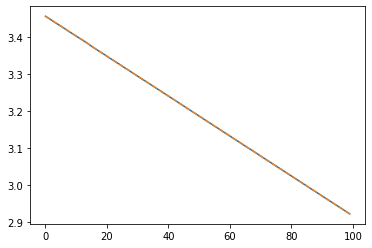

In [43]:
plt.plot(x[:100])
plt.plot(z_guess[:100], linestyle='dashed')

In [ ]:
aggregate = Aggregate_plot(olg, t_0 = 0, t_1 = 100, name = 'test');
aggregate.create(alpha=.5, linestyle='dashed');
aggregate.update(alpha = 1.)